In [1]:
import os
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from tqdm import tqdm

In [2]:
from code import model
from code.data import Dataset

In [3]:
root = os.getcwd()
batch = 8
forecast = 30
samples = 5
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = "cpu"

# Model

In [4]:
dataset = Dataset(path=os.path.join(root, "training.csv"))

In [5]:
encoder = model.Extractor(in_channels=1, out_channels=1)
decoder = model.Decoder(classes=forecast) # forcast 30 days


predictor = model.Model(encoder=encoder, decoder=decoder).to(device)
optimizer = torch.optim.Adam(predictor.parameters(), lr=1e-4)

In [6]:
trainloader = DataLoader(dataset, batch_size=batch, shuffle=False, num_workers=2)

In [ ]:
predictor.train()

for epoch in range(2000):

    epoch_loss = 0
    
    for index, data in tqdm(enumerate(trainloader)):

        optimizer.zero_grad()

        ref, gt = data # batch, 100, 4
        gt = gt[:, :, 0].to(device, dtype=torch.float)
 
        
        ref = torch.unsqueeze(ref, 1) # batch, channels, 100, 4
        ref = torch.transpose(ref, 2, 3) # batch, channels, 4, 100
        ref = ref.to(device, dtype=torch.float)

        _, pr = predictor(ref)

        
        pos = torch.isnan(gt)
        pos = ~ pos
        
        gt = gt[pos]
        pr = pr[pos]
#         gt = gt.view(batch, -1)
#         pr = pr.view(batch, -1)
        
        
        loss = torch.tensor(0, dtype=torch.float).to(device)

        ### sampling
        for sample in range(samples):
#             for _gt, _pr in zip(gt, pr):
        
            _gt = gt
            _pr = pr
            
            src = (torch.rand(_gt.size(0)) * _gt.size(0)).long()
            det = (torch.rand(_gt.size(0)) * _gt.size(0)).long()


            y_gt = _gt[det] - _gt[src]
            y_pr = _pr[det] - _pr[src]

            y_gt = torch.where(y_gt >= 0, torch.ones_like(y_gt), torch.zeros_like(y_gt))

            y_pr = nn.Sigmoid()(y_pr)


            loss += nn.BCELoss()(y_pr, y_gt)
                
        loss.backward()
        optimizer.step()
    
        epoch_loss += loss.item()
    
    print("\nEpoch: {}, bce= {:.3f}".format(epoch+1, epoch_loss))
 

25it [00:01, 14.43it/s]

In [ ]:
predictor.eval()

gts = []
prs = []

for index, data in tqdm(enumerate(trainloader)):

    data, gt = data # batch, 100, 4
    gt = gt[:, :, 0].to(device, dtype=torch.float)
    
    data = torch.unsqueeze(data, 1) # batch, channels, 100, 4
    data = torch.transpose(data, 2, 3) # batch, channels, 4, 100

    data = data.to(device, dtype=torch.float)

    _, pr = predictor(data)
    
    
    

In [11]:
nn.BCELoss()(torch.tensor(np.nan), torch.tensor(0.2))

RuntimeError: all elements of input should be between 0 and 1

In [ ]:
checkpoint = {
    'model_stat': predictor.state_dict(),
    'optimizer_stat': optimizer.state_dict(),
}

torch.save(checkpoint, os.path.join(root,
                                    "code",
                                    "pred_1.pth"))

In [ ]:
pred = predictor

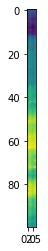

In [12]:
plt.imshow(dataset[0])

In [26]:
dataset[1259]

array([], shape=(0, 4), dtype=float64)

In [24]:
len(dataset)

1158